Download links:
- TreeCoverLoss : https://data.globalforestwatch.org/documents/941f17325a494ed78c4817f9bb20f33a/explore

# Method :


In [19]:
raster.crs

CRS.from_epsg(4326)

In [ ]:
# /Users/arthurcalvi/Data/Disturbances_maps/TreeCoverLoss/France

In [16]:
import rasterio 
import os

directory = '/Users/arthurcalvi/Data/Disturbances_maps/TreeCoverLoss/France/merged.tif'
raster = rasterio.open(directory)
bounds = -5.844727,41.211722,9.799805,51.426614

#read the window of the raster that is within the bounds
window = raster.window(*bounds)
array = raster.read(1, window=window)

window_transform = raster.window_transform(window)
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(array, cmap='pink')

In [29]:
#Converting to GeoDataFrame (~8min)

from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

#masking nodata
import numpy.ma as ma 

mask = (array == 0) 
array_ma = ma.masked_array(array, mask=mask)

shape_gen = ((shape(s), int(v)) for s,v in  shapes(array_ma, transform=window_transform))
gdf1 = gpd.GeoDataFrame(dict(zip(["geometry", "year"], zip(*shape_gen))), crs=raster.crs)


In [30]:
gdf1.to_crs(epsg=2154).to_parquet('../data/processed_datasets/TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')

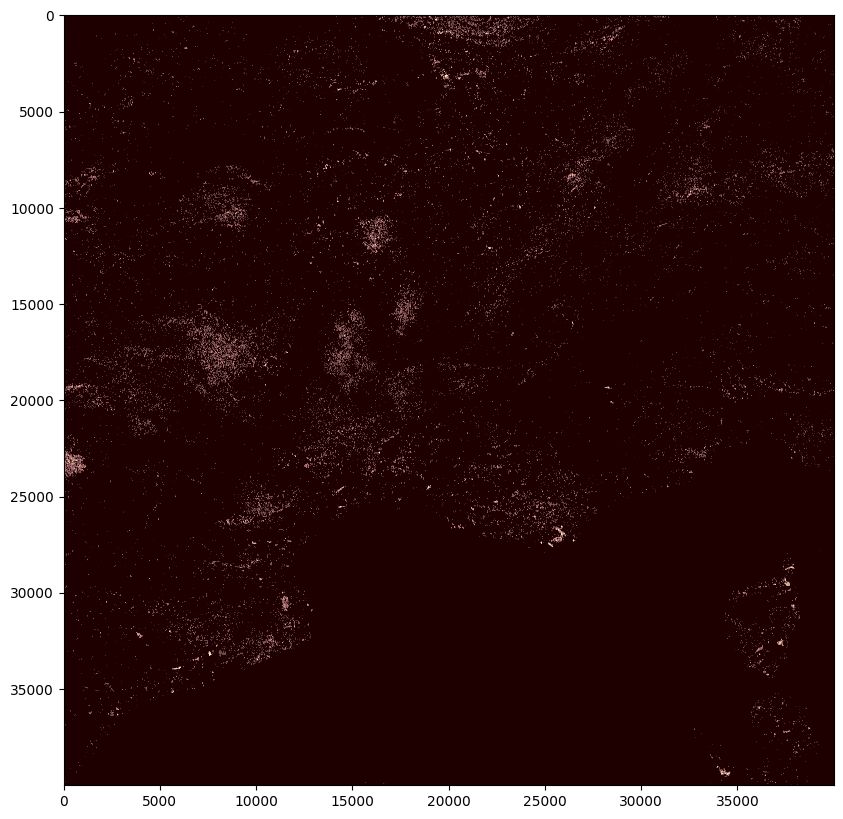

In [17]:
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(rasters[4].squeeze(), cmap='pink', vmin=1, vmax=21)


## Clip

In [32]:
import geopandas as gpd 
tcl = gpd.read_parquet('../data/processed_datasets/TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
fr = gpd.read_parquet('../data/processed_datasets/france_EPSG2154.parquet')

<Axes: >

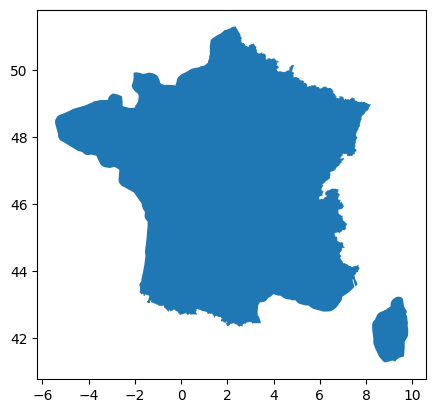

In [12]:
fr.plot()

In [33]:
a = tcl.bounds
a.minx.min(), a.maxx.max(), a.miny.min(), a.maxy.max()

(-42507.327012690366, 1253704.5149863772, 6013141.802886609, 7168104.945224638)

In [34]:
tcl_ = tcl.clip(fr.iloc[0].geometry)

In [36]:
tcl_.shape

(3048081, 2)

In [38]:
tcl_.to_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')

# Simplified

In [17]:
import geopandas as gpd

tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
bdforet30 = gpd.read_parquet('../data/processed_datasets/BDFORET_EPSG2154_FR_simplified30.parquet')

In [18]:
import pandas as pd
import numpy as np

def get_tree_species(row):
    index = bdforet30.sindex.query(row.geometry, predicate='intersects')
    if len(index) == 1:
        index = index[0]
        return bdforet30.iloc[index][['tree_type', 'essence']]
    elif len(index) > 1:
        sub = bdforet30.iloc[index]
        if len(sub.tree_type.unique().tolist()) > 1:
            tree_type = 'Mixed' 
        else : 
            tree_type = sub.tree_type.iloc[0] if type(sub.tree_type.iloc[0]) == str else np.nan 
        essence = ",".join([x for x in sub.essence.unique().tolist() if type(x) == str])
        #put in a pandas series with tree_type and essence as row names
        return pd.Series([tree_type, essence], index=['tree_type', 'essence'])
    else :
        return None, None

In [22]:
tcl[['tree_type', 'essence']] = tcl.apply(get_tree_species, axis=1, result_type='expand')

In [23]:
tcl.to_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')